In [1]:
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

In [2]:
from utilities.utilities import *
from utilities.diffGrad import *
from models.FCN import *
from models.FourierFCN import FourierFCN2D

In [4]:
w, l, T = 1.0, 1.0, 1.0
size = 10
dim = 2

In [5]:
E = 1
nu= 0.25

lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu  = E / (2 + 2 * nu)

In [6]:
config = {
    
}

equations = {
    'equation-1': {
        'points': get_points(fixed={}, size=size, dim=dim),
        'derivatives': [(0, 0, 0), (1, 0, 1), (0, 1, 1)],
        'phi': lambda x1, x2, x3: (lam + mu) * (x1 + x2) + mu * (x1 + x3),
        'psi': lambda x: torch.tensor([[0.0]]),
        'regularization': 1.0
    },
    'equation-2': {
        'points': get_points(fixed={}, size=size, dim=dim),
        'derivatives': [(0, 0, 1), (1, 1, 1), (1, 0, 0)],
        'phi': lambda x1, x2, x3: (lam + mu) * (x1 + x2) + mu * (x2 + x3),
        'psi': lambda x: torch.tensor([[0.0]]),
        'regularization': 1.0
    },
    'bound-3': {
        'points': get_points(fixed={1: l}, size=size, dim=dim),
        'derivatives': [(1, )],
        'phi': lambda x: x,
        'psi': lambda x: torch.tensor([[0.0]], dtype=torch.float),
        'regularization': size
    },
    'bound-4': {
        'points': get_points(fixed={0: 0.0}, size=size, dim=dim),
        'derivatives': [(0, )],
        'phi': lambda x: x,
        'psi': lambda x: torch.tensor([[0.1]], dtype=torch.float),
        'regularization': 1.0
    },
    'bound-5': {
        'points': get_points(fixed={0: w}, size=size, dim=dim),
        'derivatives': [(0, )],
        'phi': lambda x: x,
        'psi': lambda x: torch.tensor([[-0.1]], dtype=torch.float),
        'regularization': 1.0
    },
    'bound-6': {
        'points': get_points(fixed={1: 0.0}, size=size, dim=dim),
        'derivatives': [(1, )],
        'phi': lambda x: x,
        'psi': lambda x: torch.tensor([[0.1]], dtype=torch.float),
        'regularization': 1.0
    }
}

In [7]:
mse = lambda x: np.mean(x ** 2)
MSE = lambda x: torch.mean(torch.abs(x) ** n)
true_solution = np.load('data/linear_elasticity/linear_1.npy')

In [8]:
points = true_solution[:, :2]
points = torch.tensor(points, dtype=torch.float).to(device)

function_values = true_solution[:, 2:]
function_values = np.sqrt(function_values[:, 0] ** 2 + function_values[:, 1] ** 2)[:, None]

In [9]:
layer_size = 8
epochs = 3000
n = 2.
restarts = 1

In [10]:
result_sizes = dict()
for l_size in range(8, 9, 8):
    results = dict()
    for (NET, name, activation) in [(FCNCustom, 'FCN [min(sin(x), x)]', lambda x: torch.min(torch.sin(x), x)), 
                                    (FCNCustom, 'FCN [max(tanh(x), x)]', lambda x: torch.max(torch.tanh(x), x)),
                                    (FCNCustom, 'FCN [sigmoid(x) * x]', lambda x: torch.sigmoid(x) * x), 
                                    (FCNCustom, 'FCN [cos(x)]', lambda x: torch.cos(x)), 
                                    (FCNCustom, 'FCN [tanh]', lambda x: torch.tanh(x))]:
        training_errors = []
        fem_test_errors = []
        best_score = 10
        best_model = None
        for _ in range(restarts):

            net = NET(output_dim=2, layer_size=l_size, activate=activation)
            errors, _ = training(net, equations, epochs=epochs, optimizer=optim.AdamW, loss=MSE)
            function_values_net = net(points)
            function_values_net = function_values_net.cpu().detach().numpy()
            function_values_net = np.sqrt(function_values_net[:, 0] ** 2 + function_values_net[:, 1] ** 2)[:, None]
            err = mse(function_values_net - function_values)
            if best_score > err:
                best_model = net
                best_score = err
                
            fem_test_errors += [err]
            training_errors += [errors]
            
        best_model.name += name
        best_model.save_model()
        
        results[name] = {
            'fem_test_errors': fem_test_errors,
            'training_errors': training_errors
        }
    result_sizes[l_size] = results

100%|██████████| 3001/3001 [00:26<00:00, 115.04it/s]


In [26]:
results_ = dict()

In [27]:
results_['FCN [cos] without orthogonality'] = results['FCN [cos(x)]']
results_['FCN [cos] with orthogonality'] = results['FCN [sigmoid(x) * x]']
results_['FCN [tanh]'] = results['FCN [tanh]']

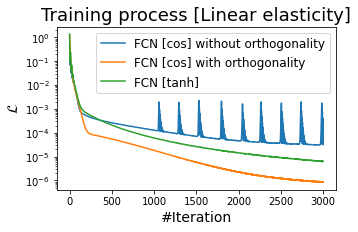

In [53]:
plt.figure(figsize=(5, 3))
plt.title('Training process [Linear elasticity]', fontsize=18)
for i, (name, values) in enumerate(results_.items()):
    
    errors = np.array(values['training_errors'])
    fem_test_errors = np.array(values['fem_test_errors']).mean()
    mean = np.mean(errors, axis=0)
    std = np.std(errors, axis=0)
    plt.semilogy(mean, label='{}'.format(name))
#     plt.semilogy(mean + std)
#     plt.semi

plt.xlabel('#Iteration', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [56]:
def plot_solutions(function_values, points, figsize=(5, 3), mesh=None):
    plt.figure(figsize=figsize)
    plt.title('ANN solution', fontsize=18)
    plt.scatter(points[:, 0], points[:, 1], c=function_values)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.colorbar()

4.1318932709949673e-07


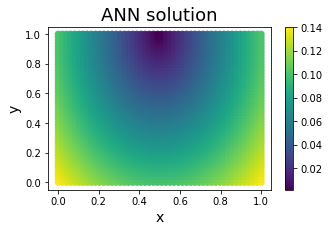

In [57]:
points = true_solution[:, :2]
points = torch.tensor(points, dtype=torch.float).to(device)

function_values_net = net(points)
function_values_net = function_values_net.cpu().detach().numpy()

function_values = true_solution[:, 2:]
function_values = np.sqrt(function_values[:, 0] ** 2 + function_values[:, 1] ** 2)[:, None]
function_values_net = np.sqrt(function_values_net[:, 0] ** 2 + function_values_net[:, 1] ** 2)[:, None]

points = points.cpu().detach().numpy()
print(mse(function_values_net - function_values))
plot_solutions(np.abs(function_values_net), points)

[]

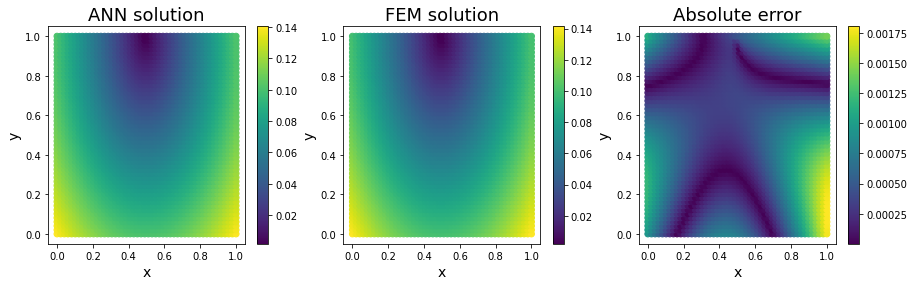

In [59]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('ANN solution', fontsize=18)
plt.scatter(points[:, 0], points[:, 1], c=function_values_net)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('FEM solution', fontsize=18)
plt.scatter(points[:, 0], points[:, 1], c=function_values)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Absolute error', fontsize=18)
plt.scatter(points[:, 0], points[:, 1], c=np.abs(function_values - function_values_net))
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.colorbar()

plt.plot()